In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import random

In [1]:
import torch
state_flat = torch.randn(64, 1800)
shape_flat = torch.randn(64, 5)
print('created state and shape tensors')
x = torch.cat([state_flat, shape_flat], dim=-1)
print(x.shape)

created state and shape tensors
torch.Size([64, 1805])


In [2]:
training_challenge_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_challenges.json'))
training_solutions_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_solutions.json'))

In [3]:
# find random keys from the training_challenge_dict
random_keys = list(training_challenge_dict.keys())
n = random.randint(0, len(random_keys))

In [4]:
#NOTE: This is our reward function

def maximum_overlap_regions(array1, array2):
        """
        Vectorized calculation of maximum overlap between two 2D arrays.
        """
        shape1 = array1.shape
        shape2 = array2.shape
        
        # Calculate possible positions for sliding array2 over array1
        offsets_i = np.arange(-shape2[0] + 1, shape1[0])
        offsets_j = np.arange(-shape2[1] + 1, shape1[1])
        
        # Create grids for all possible offsets
        grid_i, grid_j = np.meshgrid(offsets_i, offsets_j, indexing='ij')
        
        # Calculate the valid overlap regions for each position
        row_start1 = np.maximum(0, grid_i)
        row_end1 = np.minimum(shape1[0], grid_i + shape2[0])
        col_start1 = np.maximum(0, grid_j)
        col_end1 = np.minimum(shape1[1], grid_j + shape2[1])
        
        row_start2 = np.maximum(0, -grid_i)
        row_end2 = row_start2 + (row_end1 - row_start1)
        col_start2 = np.maximum(0, -grid_j)
        col_end2 = col_start2 + (col_end1 - col_start1)
        
        # Calculate overlap scores for all positions
        max_overlap_score = 0
        best_overlap1 = None
        best_overlap2 = None
        
        for idx in np.ndindex(grid_i.shape):
            r1s, r1e = row_start1[idx], row_end1[idx]
            c1s, c1e = col_start1[idx], col_end1[idx]
            r2s, r2e = row_start2[idx], row_end2[idx]
            c2s, c2e = col_start2[idx], col_end2[idx]
            
            region1 = array1[r1s:r1e, c1s:c1e]
            region2 = array2[r2s:r2e, c2s:c2e]
            
            overlap_score = np.sum(region1 == region2)
            
            if overlap_score > max_overlap_score:
                max_overlap_score = overlap_score
                best_overlap1 = (slice(r1s, r1e), slice(c1s, c1e))
                best_overlap2 = (slice(r2s, r2e), slice(c2s, c2e))
        
        return best_overlap1, best_overlap2

array1 = np.random.randint(0, 9, (30, 30))

array2 = np.array([[1, 2, 0],
                  [5, 6, 0],
                  [9, 0, 0],
                  [0, 0, 0]])

overlap1, overlap2 = maximum_overlap_regions(array1, array2)
print(array1[overlap1])
print(array2[overlap2])
print(array1[overlap1] == array2[overlap2])
print(np.sum(array1[overlap1] == array2[overlap2]))


[[1 1 0]
 [6 6 0]
 [3 8 0]
 [8 0 8]]
[[1 2 0]
 [5 6 0]
 [9 0 0]
 [0 0 0]]
[[ True False  True]
 [False  True  True]
 [False False  True]
 [False  True False]]
6


## Difficult problems
- a64e4611
- cbded52d
- 508bd3b6


# Test Selections and Transformations

In [5]:
# import the display_challenge function
from dsl.utilities.plot import display_challenge, plot_grid

# find the first challenge and solution
challenge_key = '1f85a75f'
challenge_key = random_keys[n]
first_challenge = training_challenge_dict[challenge_key]
first_solution = training_solutions_dict[challenge_key]

print(f'Challenge key: {challenge_key}')

# display the challenge
display_challenge(challenge_key)

Challenge key: 63613498


NameError: name 'training_challenge_dict' is not defined

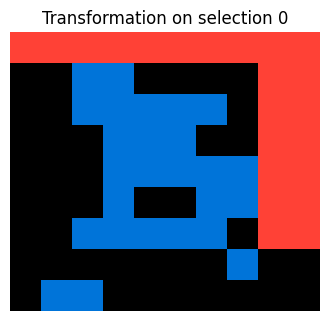

In [6]:
from dsl.utilities.plot import plot_grid 
arr = np.array([
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 1, 1, 0, 0, 0, 0, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 0, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 1, 1, 2, 2],
       [0, 0, 0, 1, 0, 0, 1, 1, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

# plot the array as an image
plot_grid(arr)

In [7]:
from dsl.color_select import ColorSelector

colsel = ColorSelector()

popular_color = colsel.mostcolor(arr)
print(f'Most popular color: {popular_color}')
least_popular_color = colsel.leastcolor(arr)
print(f'Least popular color: {least_popular_color}')

second_most_popular_color = colsel.rankcolor(arr, 1)
print(f'Second most popular color: {second_most_popular_color}')

color_of_second_biggest_shape = colsel.rank_largest_shape_color_nodiag(arr, 1)
print(f'Color of second biggest shape: {color_of_second_biggest_shape}')

color_of_second_biggest_shape = colsel.rank_largest_shape_color_diag(arr, 1)
print(f'Color of second biggest shape: {color_of_second_biggest_shape}')

Most popular color: 0
Least popular color: 2
Second most popular color: 1
Color of second biggest shape: 1
Color of second biggest shape: 1


Selecting by color


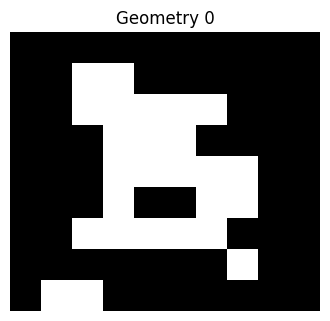

Selecting colored rectange combinations


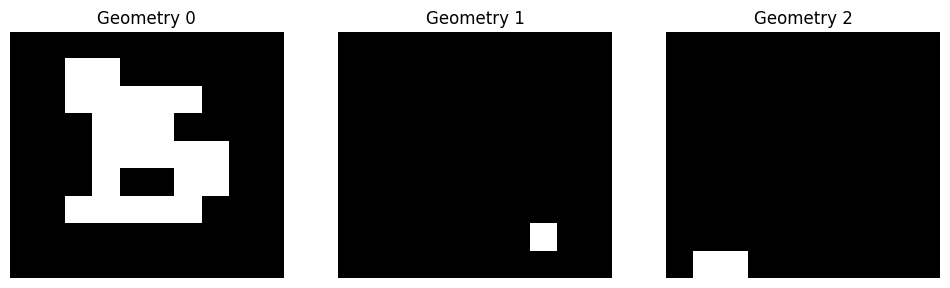

Selecting cells adjacent to color


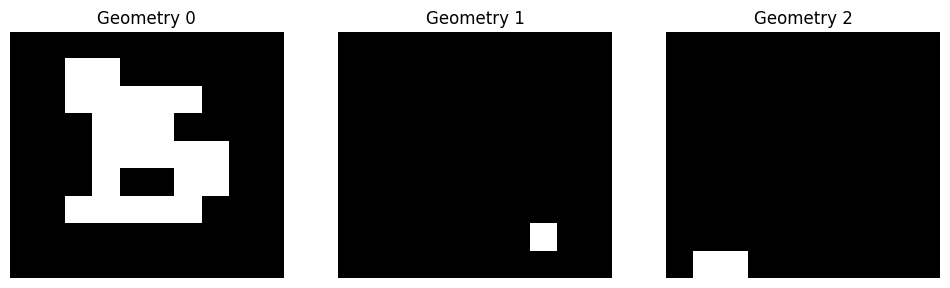

In [8]:
from dsl.select import Selector
from dsl.utilities.plot import plot_selection
from skimage.segmentation import find_boundaries

sel = Selector()

print('Selecting by color')
selection = sel.select_color(arr, 1)
plot_selection(selection)

print('Selecting colored rectange combinations')
selection3 = sel.select_connected_shapes(arr, 1)
plot_selection(selection3)

print('Selecting cells adjacent to color')
selection4 = sel.select_connected_shapes(arr, 1)
plot_selection(selection4)

# Test Reinforcement learning loop

In [9]:
from action_space import ARCActionSpace
from dsl.transform import Transformer
from dsl.utilities.plot import plot_grid_3d
trn = Transformer()

action_space = ARCActionSpace(colsel, sel, trn)


proto_action = np.array([0.5, 0.5, 0.5])
distances, indices, actions = action_space.search_point(proto_action, k=100)
print('Closest actions:', actions[:5])
print(actions.shape)

Closest actions: [[0.45454547 0.47474748 0.47147146]
 [0.45454547 0.47474748 0.5375375 ]
 [0.45454547 0.53535354 0.47147146]
 [0.5555556  0.47474748 0.47147146]
 [0.45454547 0.53535354 0.5375375 ]]
(100, 3)


In [10]:
from enviroment import ARC_Env

env = ARC_Env(training_challenge_dict, action_space=action_space, seed=0)
seed = np.random.seed(1)
random.seed(0)
env.reset()

i = 0
while False:
    i += 1
    action = random.choice(action_space.space)
    state, reward, done, info = env.step(action)
    if i % 1000 == 0:
        print(f'Step: {i}')
        env.reset()

In [21]:
import numpy as np

def enlarge(grid, selection, radius):
    """
    Enlarges the selected shape in the grid by a given radius, adding rows and columns of zeros between existing rows and columns.
    
    Args:
        grid (np.ndarray): The original input grid
        selection (np.ndarray): A binary mask indicating the shape (same shape as grid)
        radius (int): Number of cells to expand outward
        
    Returns:
        np.ndarray: A new grid with the enlarged shape
    #TODO: In the DRL environment radius will probably have to be an iterable for low numbers (likely between 1 and 3)
    """
    # Ensure grid and selection are the same shape
    assert grid.shape == selection.shape, "Grid and each selection layer must have the same shape."
    
    rows, cols = grid.shape
    # Create a larger grid with interstitial spaces
    new_rows = rows * 2 - 1
    new_cols = cols * 2 - 1
    
    # Add padding for the expansion
    pad_rows = radius
    pad_cols = radius
    total_rows = new_rows + 2 * pad_rows
    total_cols = new_cols + 2 * pad_cols
    
    # Create padded grid with zeros
    padded_grid = np.zeros((total_rows, total_cols), dtype=grid.dtype)
    padded_selection = np.zeros((total_rows, total_cols), dtype=selection.dtype)
    
    
    # Fill original positions (accounting for padding offset)
    for i in range(rows):
        for j in range(cols):
            if selection[i, j] == 1 and grid[i, j] == 1:
                padded_grid[pad_rows + i*2, pad_cols + j*2] = 1
                padded_selection[pad_rows + i*2, pad_cols + j*2] = 1
    
    # Find all non-zero elements in the grid (enlargement origins)
    enlargement_origins = np.argwhere(padded_grid != 0)

    # Iterate over each origin
    for origin in enlargement_origins:
        row, col = origin

        # Vertical (upwards)
        for r in range(1, radius + 1):
            if row - r >= 0:  # Ensure we don't go out of bounds
                padded_grid[row - r, col] = 1

        # Horizontal (rightwards)
        for c in range(1, radius + 1):
            if col + c < padded_grid.shape[1]:  # Ensure we don't go out of bounds
                padded_grid[row, col + c] = 1

        # Diagonal (right-up)
        for d in range(1, radius + 1):
            if row - d >= 0 and col + d < padded_grid.shape[1]:  # Ensure we don't go out of bounds
                padded_grid[row - d, col + d] = 1

    return padded_grid


# Test the function
grid = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
])

selection = np.array([
    [0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
])

# Enlarge the selection with a radius of 1 and include diagonal neighbors
result = enlarge(grid, selection, radius=1)

# Print results
print("\nOriginal Grid:")
print(grid)
print("\nEnlarged Grid:")
print(result)




Original Grid:
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 0 0 0 0]
 [1 1 0 0 0 0]
 [1 1 0 0 0 0]]

Enlarged Grid:
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [7]:
grid = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0],
])

grid = np.expand_dims(grid, axis=0)
print(grid.shape)

def grid_to_tokens(grid):
    """
    Converts a grid to a list of tokens.
    
    Args:
        grid (np.ndarray): The input grid
        
    Returns:
        list: A list of tokens
    """
    tokens = np.zeros(grid.size +2, dtype=np.float32)
    d, nrows, ncols = grid.shape
    tokens[0] = nrows
    tokens[1] = ncols
    tokens[2:] = grid.flatten()
    return tokens

tokens = grid_to_tokens(grid)
print(tokens)


(1, 5, 6)


ValueError: too many values to unpack (expected 2)

In [22]:
import numpy as np

def downscale(grid, scale_factor, aggregation_fn=np.max):
    """
    Downscales a grid by a given scale factor using a specified aggregation function.
    
    Args:
        grid (np.ndarray): The input grid to downscale.
        scale_factor (int): The factor by which to reduce the grid's size.
        aggregation_fn (callable): The function to aggregate values in each block (default: np.max).
    
    Returns:
        np.ndarray: The downscaled grid.
    """
    assert grid.shape[0] % scale_factor == 0 and grid.shape[1] % scale_factor == 0, \
        "Grid dimensions must be divisible by scale_factor."
    
    rows, cols = grid.shape
    new_rows = rows // scale_factor
    new_cols = cols // scale_factor

    # Create the downscaled grid
    downscaled_grid = np.zeros((new_rows, new_cols), dtype=grid.dtype)

    # Iterate over blocks and apply aggregation function
    for i in range(new_rows):
        for j in range(new_cols):
            block = grid[
                i * scale_factor:(i + 1) * scale_factor,
                j * scale_factor:(j + 1) * scale_factor
            ]
            downscaled_grid[i, j] = aggregation_fn(block)

    return downscaled_grid

# Test the function
grid = np.array([
    [0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 0]
])

selection = np.array([
    [0, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0],
    [1, 1, 1, 0, 0, 0]
])

# Enlarge the selection with a radius of 1
result = downscale(grid, 3)

print("\nOriginal Grid:")
print(grid)
print("\nEnlarged Grid:")
print(result.astype(int))  # Convert to int for cleaner printing


AssertionError: Grid dimensions must be divisible by scale_factor.

Testing

In [ ]:
import numpy as np
from dsl.select import Selector
from dsl.transform import Transformer     
from dsl.transform import Transformer
from dsl.utilities.plot import plot_grid_3d, plot_selection, plot_grid


arr = np.array([
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 1, 1, 0, 0, 0, 0, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 0, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 1, 1, 2, 2],
       [0, 0, 0, 1, 0, 0, 1, 1, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

# plot the array as an image
plot_grid(arr)
sel = Selector(arr.shape)
trn = Transformer()
print('Selecting cells adjacent to color')
selection4 = sel.select_connected_shapes(arr, 1)
plot_selection(selection4)
print('Shift cells')
transformed5 = trn.change_background_color(arr, selection4,7)
plot_grid_3d(transformed5)

In [ ]:
import numpy as np
from dsl.select import Selector
from dsl.transform import Transformer     
from dsl.transform import Transformer
from dsl.utilities.plot import plot_grid_3d, plot_selection, plot_grid


arr1 = np.array([
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 1, 1, 0, 0, 0, 0, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 0, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 1, 1, 2, 2],
       [0, 0, 0, 1, 0, 0, 1, 1, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

arr2 = np.array([
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 1, 1, 0, 0, 0, 0, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 0, 0, 2, 2],
       [0, 0, 0, 1, 1, 1, 1, 1, 2, 2],
       [0, 0, 0, 1, 0, 0, 1, 1, 2, 2],
       [0, 0, 1, 1, 1, 1, 1, 0, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]])

# plot the array as an image
plot_grid(arr1)
sel1 = Selector(arr1.shape)
sel2 = Selector(arr2.shape)
trn = Transformer()
print('Selecting cells adjacent to color')
selection4 = sel1.select_connected_shapes(arr1, 1)
selection5 = sel2.select_connected_shapes(arr2, 1)
plot_selection(selection4)
print('Vupscale')
transformed5 = trn.vupscale(arr1, selection4, 2)
plot_grid_3d(transformed5)
print('Vectorized Vupscale')
transformed6 = trn.vectorized_vupscale(arr2, selection4, 2)
plot_grid_3d(transformed6)

In [ ]:
import numpy as np
from dsl.select import Selector
from dsl.transform import Transformer     
from dsl.transform import Transformer
from dsl.utilities.plot import plot_grid_3d, plot_selection, plot_grid
from dsl.utilities.transformation_utilities import center_of_mass


arr1 = np.array([
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 1, 1, 1, 1, 0, 0, 0, 2],
       [2, 0, 1, 0, 0, 1, 0, 0, 0, 2],
       [2, 0, 1, 1, 1, 1, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 1, 1, 1, 2],
       [2, 0, 0, 0, 0, 0, 1, 0, 1, 2],
       [2, 0, 0, 0, 0, 0, 1, 1, 1, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

arr2 = np.array([
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 2],
       [2, 0, 1, 1, 1, 1, 0, 0, 0, 2],
       [2, 0, 1, 0, 0, 1, 0, 0, 0, 2],
       [2, 0, 1, 1, 1, 1, 0, 0, 0, 2],
       [2, 0, 0, 0, 0, 0, 1, 1, 1, 2],
       [2, 0, 0, 0, 0, 0, 1, 0, 1, 2],
       [2, 0, 0, 0, 0, 0, 1, 1, 1, 2],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])

# plot the array as an image
plot_grid(arr1)
sel1 = Selector(arr1.shape)
sel2 = Selector(arr2.shape)
trn = Transformer()
print('Selecting cells adjacent to color')
selection4 = sel1.select_connected_shapes(arr1, 1)
selection5 = sel2.select_connected_shapes(arr2, 1)
plot_selection(selection4)
print('Vupscale')
transformed5 = trn.vupscale(arr1, selection4, 2)
plot_grid_3d(transformed5)
print('Vectorized Vupscale')
transformed6 = trn.vectorized_vupscale(arr2, selection4, 2)
plot_grid_3d(transformed6)



CoM1 = center_of_mass(selection4[0])
CoM2 = center_of_mass(selection4[1])
print(f'Center of mass of shape 0: {CoM1}')
print(f'Center of mass of shape 1: {CoM2}')

In [55]:
import numpy as np
import time

def maximum_overlap_regions_old(array1, array2):
        """
        Vectorized calculation of maximum overlap between two 2D arrays.
        """
        shape1 = array1.shape
        shape2 = array2.shape
        
        # Calculate possible positions for sliding array2 over array1
        offsets_i = np.arange(-shape2[0] + 1, shape1[0])
        offsets_j = np.arange(-shape2[1] + 1, shape1[1])
        
        # Create grids for all possible offsets
        grid_i, grid_j = np.meshgrid(offsets_i, offsets_j, indexing='ij')
        
        # Calculate the valid overlap regions for each position
        row_start1 = np.maximum(0, grid_i)
        row_end1 = np.minimum(shape1[0], grid_i + shape2[0])
        col_start1 = np.maximum(0, grid_j)
        col_end1 = np.minimum(shape1[1], grid_j + shape2[1])
        
        row_start2 = np.maximum(0, -grid_i)
        row_end2 = row_start2 + (row_end1 - row_start1)
        col_start2 = np.maximum(0, -grid_j)
        col_end2 = col_start2 + (col_end1 - col_start1)
        
        # Calculate overlap scores for all positions
        max_overlap_score = 0
        best_overlap1 = None
        best_overlap2 = None
        
        for idx in np.ndindex(grid_i.shape):
            r1s, r1e = row_start1[idx], row_end1[idx]
            c1s, c1e = col_start1[idx], col_end1[idx]
            r2s, r2e = row_start2[idx], row_end2[idx]
            c2s, c2e = col_start2[idx], col_end2[idx]
            
            region1 = array1[r1s:r1e, c1s:c1e]
            region2 = array2[r2s:r2e, c2s:c2e]
            
            overlap_score = np.sum(region1 == region2)
            
            if overlap_score > max_overlap_score:
                max_overlap_score = overlap_score
                best_overlap1 = (slice(r1s, r1e), slice(c1s, c1e))
                best_overlap2 = (slice(r2s, r2e), slice(c2s, c2e))
        
        return best_overlap1, best_overlap2
# Functions to test
def test_overlap_functions():
    def generate_random_grids(max_size=30):
        size1 = np.random.randint(2, max_size+1, size=2)  # Random size for grid 1
        size2 = np.random.randint(2, max_size+1, size=2)  # Random size for grid 2
        grid1 = np.random.randint(0, 5, size=size1)       # Random grid 1 with values 0-4
        grid2 = np.random.randint(0, 5, size=size2)       # Random grid 2 with values 0-4
        return grid1, grid2

    num_tests = 10
    max_size = 5

    old_times = []
    new_times = []

    for test_idx in range(num_tests):
        grid1, grid2 = generate_random_grids(max_size)

        # Test old function
        start_time = time.time()
        old_result1, old_result2 = maximum_overlap_regions_old(grid1, grid2)
        old_times.append(time.time() - start_time)

        # Test new function
        start_time = time.time()
        new_result1, new_result2 = maximum_overlap_regions(grid1, grid2)
        new_times.append(time.time() - start_time)

        # Verify that the results match
        if old_result1 != new_result1 or old_result2 != new_result2:
            print(f"Mismatch on test {test_idx}:")
            print("Grid1:")
            print(grid1)
            print("Grid2:")
            print(grid2)
            print("Old function results:")
            print(old_result1, old_result2)
            print(grid1[old_result1])
            print(grid2[old_result2])
            print('Overlap:', np.sum(grid1[old_result1] == grid2[old_result2]))
            print('')
            print("New function results:")
            print(new_result1, new_result2)
            print(grid1[new_result1])
            print(grid2[new_result2])
            print('Overlap:', np.sum(grid1[new_result1] == grid2[new_result2]))
            raise AssertionError(f"Mismatch in results on test {test_idx}")

        print(f"Test {test_idx + 1}/{num_tests}: PASSED")

    print(f"\nAverage time for old function: {np.mean(old_times):.6f} seconds")
    print(f"Average time for new function: {np.mean(new_times):.6f} seconds")

# Run the tests
test_overlap_functions()


ValueError: operands could not be broadcast together with shapes (6,5) (3,1) 